# Credit Card Fraud Detection with AutoXGB
## Part 1 - Data Acquisition and Processing
___

### Setup dependencies and dataset

In [1]:
# Library imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pickle
import datetime
import shutil

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

### Download raw data
- Data source: https://github.com/Fraud-Detection-Handbook/simulated-data-transformed

In [2]:
# Download raw data
dst_folder = 'data/raw'

if not os.path.exists(dst_folder):
    os.makedirs(dst_folder)
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed/ data/raw

In [3]:
# Show all pickle files (raw data)
os.listdir(f'{dst_folder}/data')

['2018-04-01.pkl',
 '2018-04-02.pkl',
 '2018-04-03.pkl',
 '2018-04-04.pkl',
 '2018-04-05.pkl',
 '2018-04-06.pkl',
 '2018-04-07.pkl',
 '2018-04-08.pkl',
 '2018-04-09.pkl',
 '2018-04-10.pkl',
 '2018-04-11.pkl',
 '2018-04-12.pkl',
 '2018-04-13.pkl',
 '2018-04-14.pkl',
 '2018-04-15.pkl',
 '2018-04-16.pkl',
 '2018-04-17.pkl',
 '2018-04-18.pkl',
 '2018-04-19.pkl',
 '2018-04-20.pkl',
 '2018-04-21.pkl',
 '2018-04-22.pkl',
 '2018-04-23.pkl',
 '2018-04-24.pkl',
 '2018-04-25.pkl',
 '2018-04-26.pkl',
 '2018-04-27.pkl',
 '2018-04-28.pkl',
 '2018-04-29.pkl',
 '2018-04-30.pkl',
 '2018-05-01.pkl',
 '2018-05-02.pkl',
 '2018-05-03.pkl',
 '2018-05-04.pkl',
 '2018-05-05.pkl',
 '2018-05-06.pkl',
 '2018-05-07.pkl',
 '2018-05-08.pkl',
 '2018-05-09.pkl',
 '2018-05-10.pkl',
 '2018-05-11.pkl',
 '2018-05-12.pkl',
 '2018-05-13.pkl',
 '2018-05-14.pkl',
 '2018-05-15.pkl',
 '2018-05-16.pkl',
 '2018-05-17.pkl',
 '2018-05-18.pkl',
 '2018-05-19.pkl',
 '2018-05-20.pkl',
 '2018-05-21.pkl',
 '2018-05-22.pkl',
 '2018-05-23

___
### Create train / test sets
- ~8 week period for **train** set: 2018-07-01 to 2018-08-27
- 1 week feedback delay between train and validation set: 2018-08-28 to 2018-09-03
- 1 week period for **test** set: 2018-09-04 to 2018-09-10

*Details on Feedback Delay Period*
- We choose our test set to take place at least one week after the last transaction of the training set
- In a fraud detection context, this period separating the training and test set is referred to as the delay period or feedback delay. 
- It accounts for the fact that, in a real-world fraud detection system, the label of a transaction (fraudulent or legitimate) is only known after a customer complaint, or thanks to the result of a fraud investigation. 
- Therefore, in a realistic scenario, the annotated data available to train a model and start making prediction for a given day are anterior to that day minus the delay period. 
- A one-week delay is, to a first approximation, a reasonable basis. From experience, statistics generally show that most of the feedback becomes available after a one week delay and empirically, it is also the point where the negative effect of considering that zero feedback is available before and the positive effect of considering that all the feedback is available after cancel each other out.

Reference: https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_5_ModelValidationAndSelection/ValidationStrategies.html

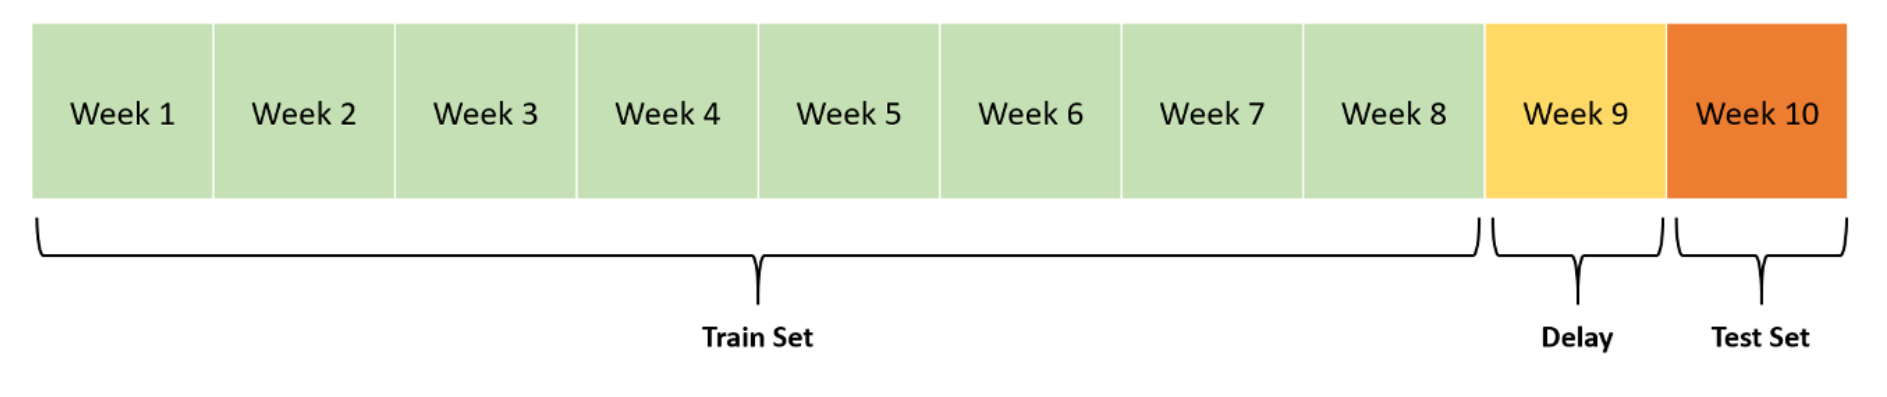

In [4]:
# Define date range for train and test sets
train_date_range = pd.date_range('2018-07-01', '2018-08-27', freq='d').strftime('%Y-%m-%d').tolist()
test_date_range = pd.date_range('2018-09-04', '2018-09-10', freq='d').strftime('%Y-%m-%d').tolist()

In [5]:
# Generate train set dataframe
train_df = pd.DataFrame()
for date in train_date_range:
    df = pd.read_pickle(f'{dst_folder}/data/{date}.pkl')
    train_df = train_df.append(df)

len(train_df)

555541

In [6]:
# Generate test set dataframe
test_df = pd.DataFrame()
for date in test_date_range:
    df = pd.read_pickle(f'{dst_folder}/data/{date}.pkl')
    test_df = test_df.append(df)

len(test_df)

67386

___
### Data Pre-Processing
- Baseline feature transformation already done on the simulated raw dataset
- Reference: https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/BaselineFeatureTransformation.html

In [7]:
# Define target variable
target = 'TX_FRAUD'

# Define predictor variables
predictors = ['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 
              'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
              'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
              'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
              'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW',
              'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW',
              'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 
              'TERMINAL_ID_NB_TX_1DAY_WINDOW',
              'TERMINAL_ID_NB_TX_7DAY_WINDOW',
              'TERMINAL_ID_NB_TX_30DAY_WINDOW',
              'TERMINAL_ID_RISK_1DAY_WINDOW', 
              'TERMINAL_ID_RISK_7DAY_WINDOW', 
              'TERMINAL_ID_RISK_30DAY_WINDOW']

In [8]:
# Keep only predictor and target columns
train_df = train_df[predictors + [target]]
test_df = test_df[predictors + [target]]

In [9]:
train_df.head()

,TX_AMOUNT,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD
872795,74.37,1,1,8.0,21.0,68.0,55.131250,52.041905,53.391618,1.0,4.0,27.0,0.0,0.0,0.037037,0
872796,109.96,1,1,4.0,26.0,109.0,107.980000,93.211154,97.145046,1.0,5.0,43.0,0.0,0.0,0.000000,0
872797,18.26,1,1,2.0,10.0,74.0,14.560000,11.060000,11.367297,1.0,4.0,18.0,0.0,0.0,0.000000,0
872798,44.44,1,1,3.0,23.0,86.0,95.513333,85.214783,91.759302,2.0,8.0,29.0,0.0,0.0,0.000000,0
872799,24.75,1,1,1.0,2.0,13.0,24.750000,37.285000,36.265385,0.0,5.0,32.0,0.0,0.0,0.031250,0


In [10]:
# Assess degree of imbalance in target label
train_df[target].value_counts(dropna=False)

0    550606
1      4935
Name: TX_FRAUD, dtype: int64

Significant degree of target label imbalance (Fraud cases only 0.9% of entire dataset)

### Perform sampling strategy
The original paper on SMOTE suggested combining SMOTE with random undersampling of the majority class.

We can execute the following strategy:
1. SMOTE oversampling to make minority class 5% of total dataset (up ~500% from original 0.9%), then
2. Random undersampling to make minority class 50% that of majority class (i.e. down-sample majority so that it is twice of minority class)

Final sampled ratio will be majority:minority = 2:1

In [11]:
# Define sampling techniques
over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

In [12]:
# Rearrange dataset into X, y sets
X_train = train_df[predictors]
y_train = train_df[target]

In [13]:
# Execute sampling strategy
X_train, y_train = pipeline.fit_resample(X_train, y_train)
len(X_train)

82590

In [14]:
# Evaluate labels of sampled dataset
y_train.value_counts(dropna=False)

0    55060
1    27530
Name: TX_FRAUD, dtype: int64

### Save Processed Datasets

In [15]:
# Set path for processed data
processed_folder = 'data/processed'
if not os.path.exists(processed_folder):
    os.makedirs(processed_folder)
    
test_df.to_csv(f'{processed_folder}/test.csv', index=False)

In [16]:
# Combine X_train and y_train together to save as processed train set
y_train_df = pd.DataFrame(y_train, columns=['TX_FRAUD'])
train_processed = pd.concat([X_train, y_train_df], axis=1)
train_processed.to_csv(f'{processed_folder}/train.csv', index=False)